# ACR Phantom

In [1]:
import numpy as np
from skimage.exposure import rescale_intensity
from scipy.ndimage.interpolation import zoom

import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, fixed

from mriqa.phantoms import phantom_mask_2d, find_phantom
from mriqa.tools import show_mosaic
from mriqa.dcmio import fetch_series

In [2]:
# ACR scan 2mm slice SE for orientation
patid = 'PQACRY20160411RHD'
stuid = '1'
sernos = [10]
dobjs = fetch_series(patid, stuid, sernos)

images = [d.pixel_array & 0xfff for d in dobjs]
pix_dims = np.asarray(dobjs[0].PixelSpacing)

interpolation_factor = 4
images = [rescale_intensity(zoom(image, interpolation_factor)) for image in images]
pix_dims /= interpolation_factor

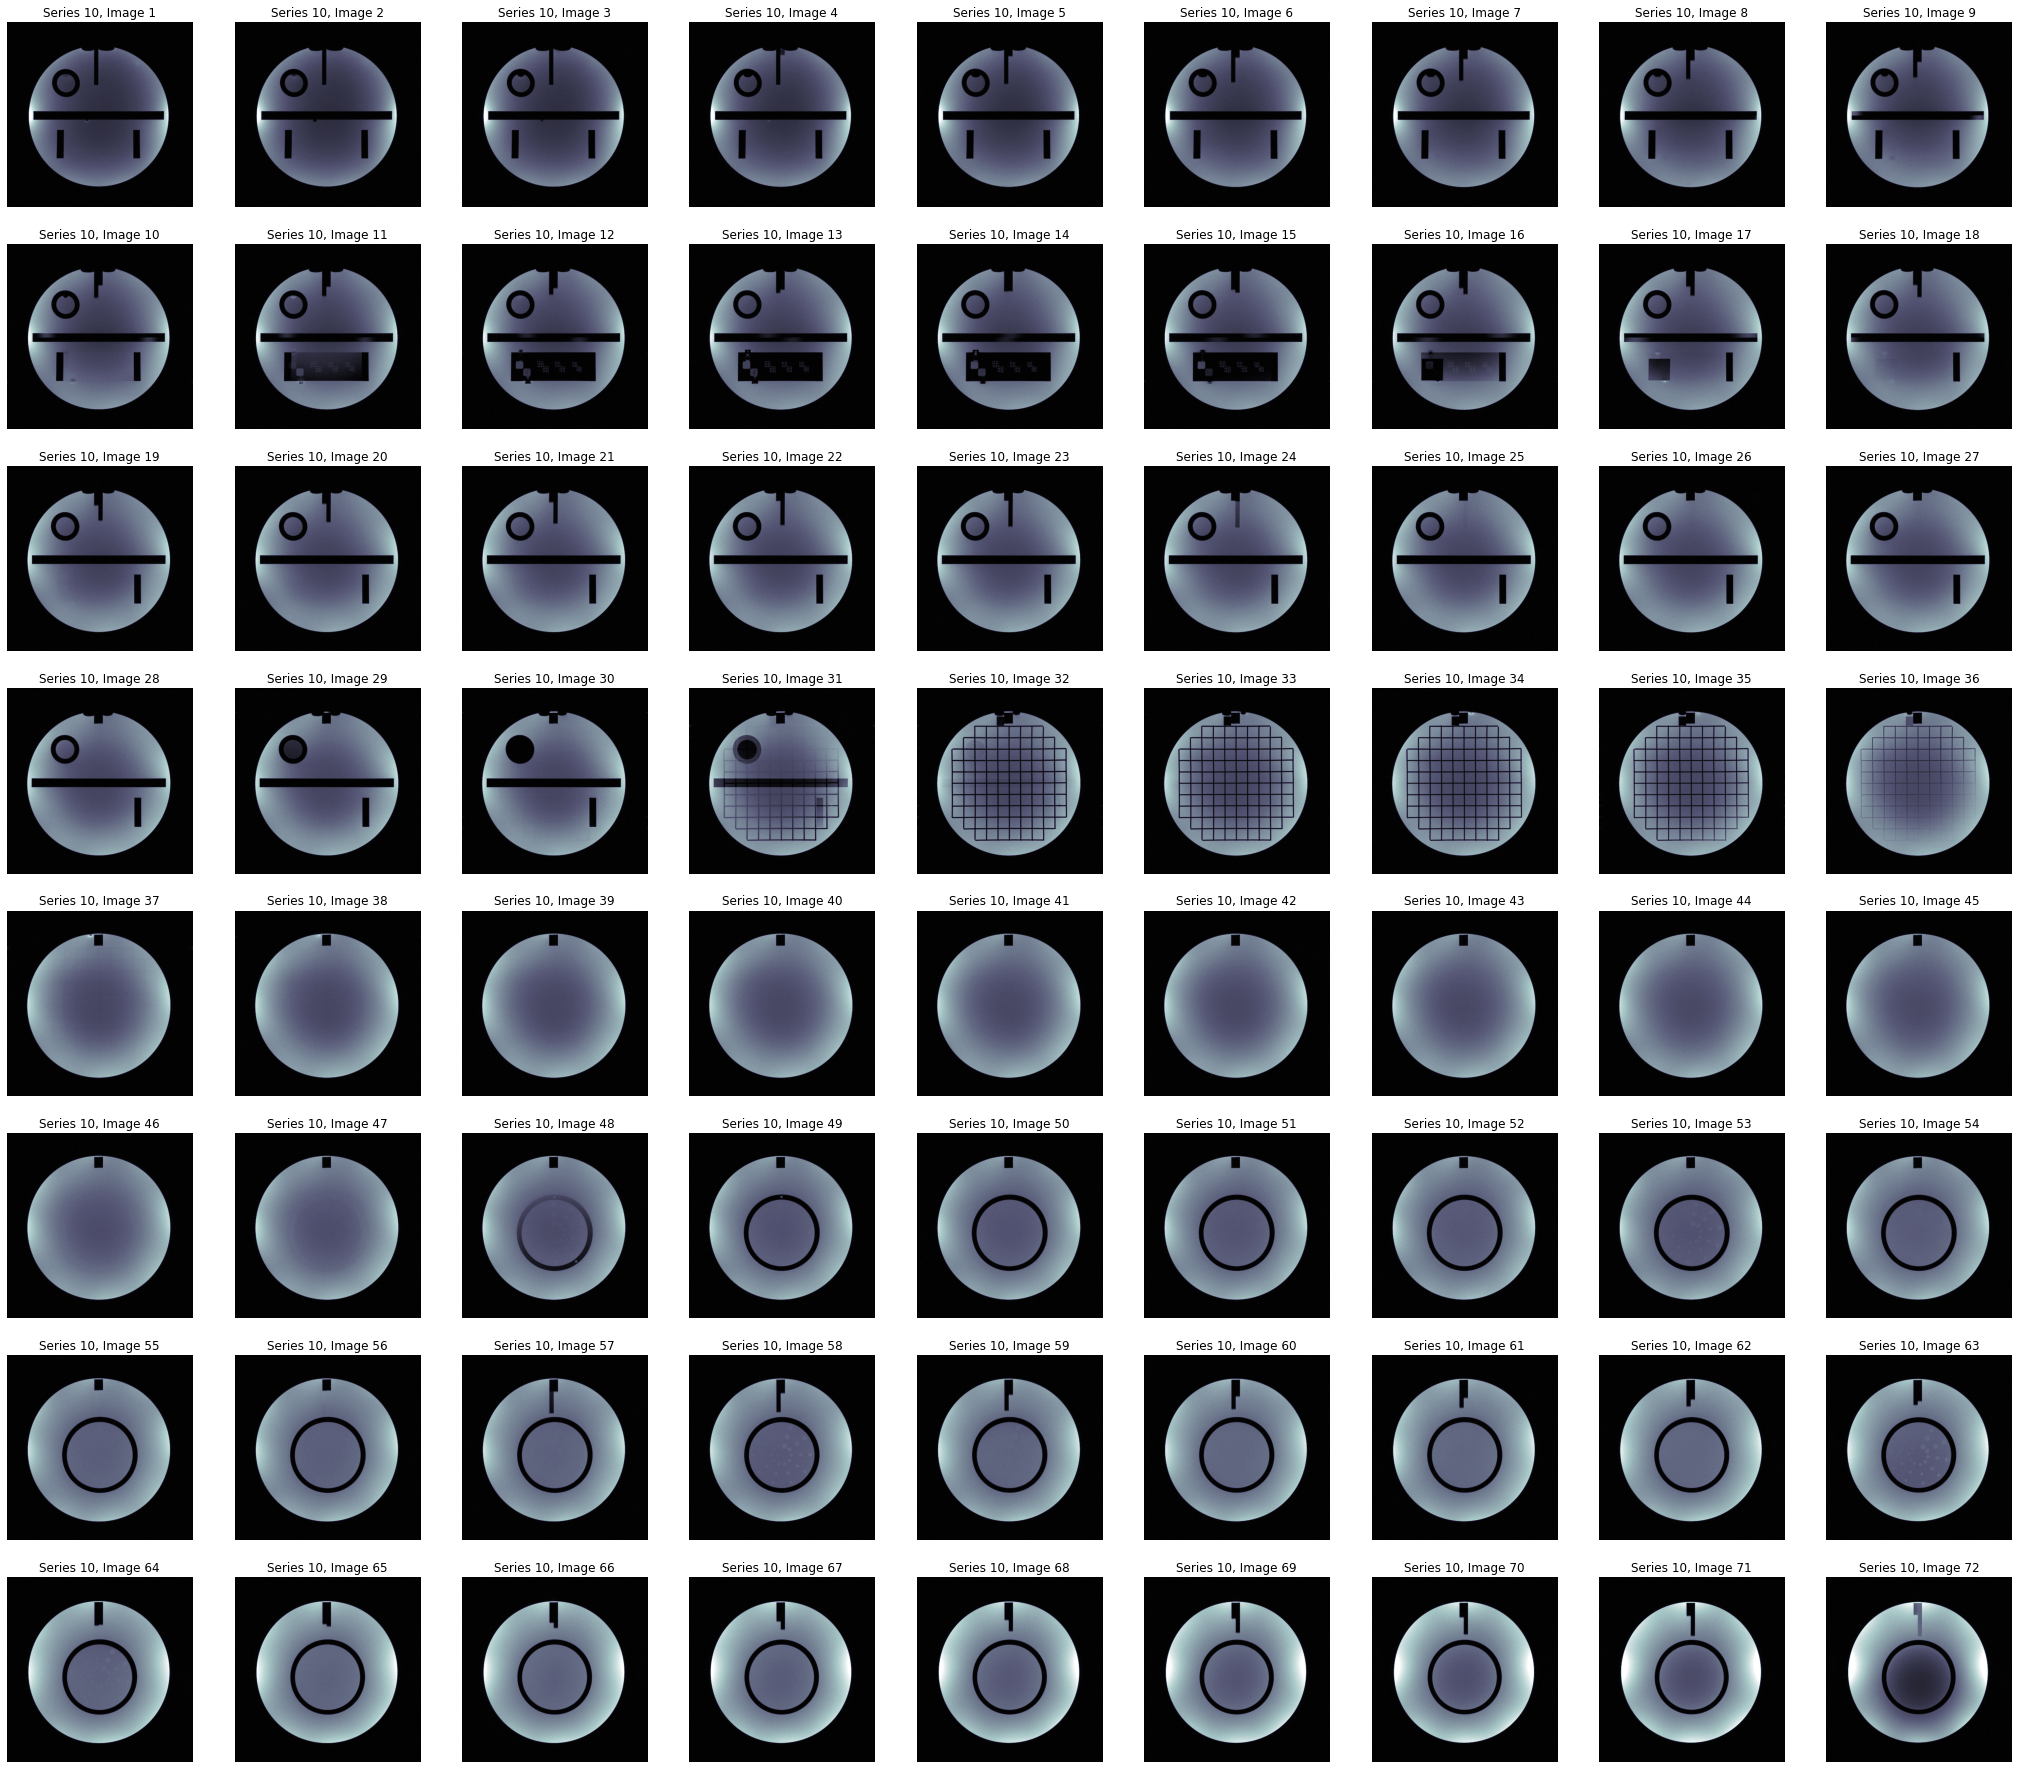

In [3]:
show_mosaic(dobjs, cmap='bone')

In [4]:
import ipywidgets as widgets
from IPython.display import display

fig, ax = plt.subplots(figsize=(12, 12))
n0 = 37
im = ax.imshow(dobjs[n0-1].pixel_array & 0xfff, cmap='viridis')

ax.grid(False)
ax.axis('off')
plt.close(fig)

@interact(n=(1, len(dobjs)))
def show_frame(n=n0):
    #fig, ax = plt.subplots(figsize=(12, 12))
    #if im is not None:
    #else:
    im.set_data(dobjs[n-1].pixel_array & 0xfff)
    ax.set_title('Slice Location: %+.1f mm' % float(dobjs[n-1].SliceLocation), fontsize=22)
    display(fig)

interactive(children=(IntSlider(value=37, description='n', max=72, min=1), Output()), _dom_classes=('widget-in…

### Measurements
#### General Notes
There are details in the [accreditation instructions](http://www.acr.org/~/media/ACR/Documents/Accreditation/MRI/LargePhantomGuidance.pdf).

This is the ACR *Large* phantom (190mm diameter, length 148mm) - filled with 10mM NiCl<sub>2</sub>, 75mM NaCl.

We could use a perfectly aligned template to remove small rotations and shifts. Gross errors
should be avoidable as there are unambiguous set up marks on the phantom. They seem to use multiple series (T<sub>1</sub>W, T<sub>2</sub>W etc) with quite course slices (5mm + 3mm). They recommend twiddling the windowing
when making measurements - we can probably do this in a more principled way.

#### Gradient Strength Calibration
For these they measure the size of the phantom so we'll want
 - Full slice coverage (or a non-axial view)
 - Sufficient BW in S/S and R/O to minimise B<sub>0</sub> effects on scale/distortion
 - Relatively easy to do with edge detection and peak location
 - In-plane they do diameter at 4 angles at the level of the distortion grid
 - Expect 190mm by 140mm  &plusmn;2mm
 - NB gradient amplifier warm up effects (really? for solid state amps?)

#### High Contrast Spatial Resolution
 - Three pairs of hole grids, UL array is for row resolution, LR array for column resolution.
 - Hole diameters are 1.1/1.0/0.9 mm, separation is twice diameter.
 - This seems pretty tricky to analyse automatically
 - Use slice at around -50mm
 - Two small square blocks in this slice too - not clear what they are for (filling ports?)

#### Slice Thickness
 - At -45mm we have what look like a pair of plates (though article calls them 'wedges' ..)
 - Angle is 5.71&deg; (10:1)
 - Slice is positive rather than negative and pretty narrow so would need careful positioning of ROIs

#### Slice Position (Laser/Couch offset)
 - Crossed (45&deg) wedges at top and bottom ends of phantom (strange - not the middle?)
 - Two vertical bars should be the same height - (Anat)-L bar longer => slice is SUP.
 - Slice displacement is half difference in height between bars
 - Careful to make block symmetric or turn off couch centring
 - Actually seem to be at -45mm and +55mm (asymmetric!)

#### Uniformity
 - Use a 45mm diameter circular ROI, central in phantom at around z=+15mm, between distortion grid and 45&deg; wedges.
 - Done for T1 and T2 series
 - Takes just spread of values: 1 - (max-min)/(max+min) (shouldn't there be a factor 2 ?)
 - Thise are from two small (1cm<sup>2</sup>) ROIs assessed by I as the max and min in the image.
 - This is hardly robust - probably stick with what we've got - the profiles or look at min/max on smoothed image
 - Action levels are 0.875 (1.5T), 0.82 (3T); pretty arbitrary (do we allow normalisation?)
 - Accurate centring in coil is crucial - especially AP, which is tricky.
 - Severe ghosting can affect this.
 
#### Ghosting
 - Same slice as uniformity, same central ROI. Four ROIs outside phantom. Size 130-140 cm<sup>2</sup>. Exact shape and location are vague.
 - Ghosting 'ratio' as we do now ...
 - Probably not applicable to EPI and Nyquist ghosts
 - Beware of vibration/motion of phantom.
 - Quadrature ghosting not really an issue any more

#### Low contrast Detectability
 - Four slices with differing contrast ratios: 1.4%, 2.5%, 3.6% and 5.1%.
 - Three size sized discs in a 'spoke'. Different angles => different sizes: 7mm -> 1.5mm
 - Need to be careful with slice thickness here as it's working by partial volume ...
 - Score by number of spokes visible
 - T1 *and* T2 sequences
 - Beware of offset of the phantom head-foot and any angulation other than around the z axis.
 

It's not very clear what the tube in the anterior-foot part of the phantom is. Also we don't know if the grid near the centre is accurate enough to be used for a distortion assessment.